Asn 2

Moushumi Pardesi

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Problem 1

Write an Encoder network with 3 linear layers that inputs MNIST images and outputs an 8-dimensional vector of means and an 8-dimensional positive vector of variances

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc_mu = nn.Linear(64, 8)
        self.fc_logvar = nn.Linear(64, 8)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

Problem 2

Write code that inputs an 8-dimensional vector $\mu$ and an 8-dimensional positive vector $\sigma$ and a sample $\varepsilon$ from an 8 -dimensional $\mathcal{N}(0, I)$ to generate a sample from $\mathcal{N}(\mu, \sigma I)$


In [3]:
def sample_from_latent(mu, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)
    z = mu + std * epsilon
    return z

Problem 3

Use your code from Problem 2. to write a Decoder network that takes a sample from $\mathcal{N}(\mu, \sigma I)$ (an 8-dimensional vector). Use 3 linear layers and ReLU activation functions and sigmoid function to output a 784-dimensional tensor, resphape it to $28 \times 28$ and plot the resulting image.

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        x_recon = torch.sigmoid(self.fc3(z))
        return x_recon.view(-1, 1, 28, 28)

Problem 4

Put the Encoder and Decoder together to write a Variational Autoencoder and train it on the MNIST dataset.

Fix an input image and use the output of the Encoder to make a $\mu$ and a $\sigma$. Make 10 samples from $\mathcal{N}(\mu, \sigma I)$ and plot the output of the Decoder on these samples.

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = sample_from_latent(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


training VAE

In [6]:
def train_vae(vae, train_loader, num_epochs=10, learning_rate=1e-3):
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    criterion = nn.BCELoss(reduction='sum')

    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = vae_loss(recon_batch, data, mu, logvar, criterion)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader.dataset)}")

VAE loss

In [7]:
def vae_loss(recon_x, x, mu, logvar, criterion):
    BCE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

samples generation and plotting

In [8]:
def generate_samples(vae, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, 8).to(device)
        samples = vae.decoder(z).cpu()
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(samples[i].view(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

loaders

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 64
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)


initialize and train

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE()
train_vae(vae, train_loader)

Epoch 1/10, Loss: 169.48852694498697
Epoch 2/10, Loss: 128.77385850423178
Epoch 3/10, Loss: 122.03365836588542
Epoch 4/10, Loss: 118.5577557454427
Epoch 5/10, Loss: 116.44623402506511
Epoch 6/10, Loss: 114.9700483194987
Epoch 7/10, Loss: 113.81037947998047
Epoch 8/10, Loss: 112.90748069661458
Epoch 9/10, Loss: 112.19294886881511
Epoch 10/10, Loss: 111.56607801513672


generate samples and plot

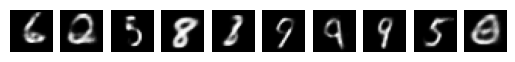

In [11]:
generate_samples(vae)